# XAI 실습
## XAI 기법 중 하나인 Grad-CAM을 통해 모델이 어떤 형태로 이미지를 판단하는지 확인
### - 실습 데이터 셋 : ImageNet dataset (ILSVRC-2012 challenge dataset)
### - 실습 모델 : 사전에 학습된 모델 (ResNet-50)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
#사전 학습된 CNN 모델을 불러옴
model = ResNet50(weights='imagenet')

### 모델 구조 확인
### - 앞선 실습에 비해 굉장히 큰 모델 (total parameter 수 확인)

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### 이미지 load

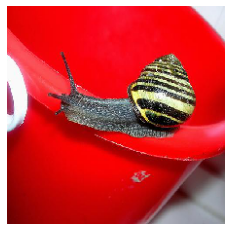

In [ ]:
#Image path: 실습 image 3개
#image_path = './sample_data/appenzeller.jpg'
image_path = './sample_data/snail.jpg'

img = image.load_img(image_path, target_size = (224,224))
plt.imshow(img)
plt.axis('off')
plt.show()

### 이미지를 모델의 입력 형태로 변환 (전처리)

In [ ]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=resnet50.preprocess_input(x)

### 모델 예측 결과 출력
### - 모델 예측 확률 기준, top-k에 해당하는 class 출력

In [ ]:
#모델 예측
preds= model.predict(x)

#모델 예측 결과 출력 (top-k)
top_k = 4
prediction_results = resnet50.decode_predictions(preds,top=top_k)[0]
top_k_idx_list = preds[0].argsort()[::-1][:top_k]
for k in range(top_k):
    print('Top-',k+1,'예측 결과')
    print('예측 class : ',prediction_results[k][1])
    print('예측 clss index : ',top_k_idx_list[k])
    print('예측 확률 : ',prediction_results[k][2])
    print('\n')

1/1 [==============================] - 1s 1s/step
Top- 1 예측 결과
예측 class :  snail
예측 clss index :  113
예측 확률 :  0.98344916


Top- 2 예측 결과
예측 class :  leaf_beetle
예측 clss index :  304
예측 확률 :  0.010562335


Top- 3 예측 결과
예측 class :  bee
예측 clss index :  309
예측 확률 :  0.0032467474


Top- 4 예측 결과
예측 class :  hip
예측 clss index :  989
예측 확률 :  0.0006584019




In [ ]:
top_k_idx_list

array([113, 304, 309, 989])

# Grad-CAM 생성
### - 모델이 예측한 top-k class에 대해서 grad-cam 생성
### - top-k class에 대한 모델 예측 원인 분석

In [ ]:
#모델의 특징 추출 부분에서 마지막 층을 지정 (penultimate layer)
#특징 추출 부분만으로 구성된 model_1만들기
last_conv_layer = model.get_layer("conv5_block3_out") # User choice
model_1= keras.Model(model.inputs, last_conv_layer.output)

#분류 (전역평균풀링 또는 완전연결층) 부분만으로 구성된 model__2만들기
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

#GradientTape함수를 이용한 그레디언트 계산
with tf.GradientTape() as tape:
    output_1 = model_1(x) #Activation 정보 (forward)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1) #모델 예측
    
    #모델 설명을 얻고자 하는 class index 설정
    class_id = top_k_idx_list[0] # top1: top_k_idx_list[0], top2: top_k_idx_list[1]
    output_2 = preds[:,class_id] #설정한 class의 예측 score

In [ ]:
grads = tape.gradient(output_2, output_1) #그레디언트 계산
alpha = tf.reduce_mean(grads,axis=(0,1,2)).numpy() # 중요도 계산
Activation = output_1.numpy()[0] #Activation 정보

cam = np.sum(alpha * Activation,axis=2) #Linear combination
cam = np.maximum(cam, 0) #ReLu

#Min-Max scaling
cam = cam - np.min(cam)
cam = cam / np.max(cam) +1e-8

#Resizing
cam = np.expand_dims(cam, axis=2)
cam = tf.squeeze(tf.image.resize(cam,(224,224))).numpy()

# Grad-CAM 시각화
### - 붉은색일수록 모델이 이미지 분류를 위해 중요하게 생각한 feature에 해당

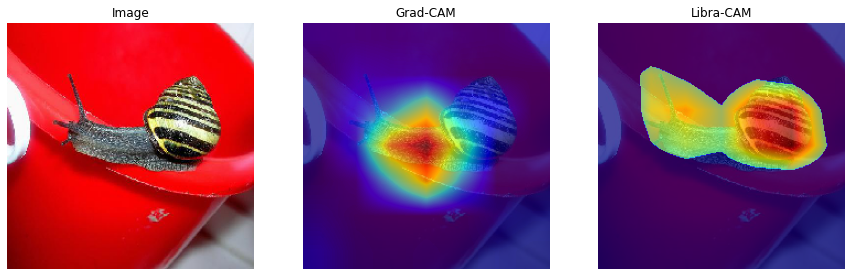

In [ ]:
img = image.load_img(image_path, target_size = (224,224)) #원본 이미지

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.01)

plt.subplot(2,3,1)
plt.imshow(img)
plt.axis("off")
plt.title('Image')

#Grad-CAM 결과
plt.subplot(2,3,2)
plt.imshow((cam),cmap='jet')
plt.imshow(img,alpha = 0.3)
plt.axis("off")
plt.title('Grad-CAM')
#plt.show()

#Libra-CAM 결과
libra_cam = np.load('./sample_data/snail_libra.npy') #Libra-CAM snali
#libra_cam = np.load('./sample_data/appenzeller_libra.npy') #Libra-CAM appenzeller
plt.subplot(2,3,3)
plt.imshow((libra_cam),cmap='jet')
plt.imshow(img,alpha = 0.3)
plt.axis("off")
plt.title('Libra-CAM')
plt.show()

# Quiz
## 아래 image에 대한 모델의 top-1,2 예측, 원인 분석 (Grad-cam 생성)
## hint- top1 class: zebra, top2 class : tusker (elephant)

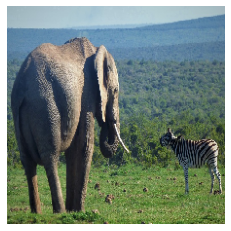

In [ ]:
image_path = './sample_data/zebra_and_elephant.jpg'

img = image.load_img(image_path, target_size = (224,224))
plt.imshow(img)
plt.axis('off')
plt.show()